In [1]:
!pip install tensorflow==2.15.0
!pip install scikit-learn
!pip install pandas
!pip install numpy
!pip install seaborn
!pip install matplotlib
!pip install wordcloud
!pip install nltk

# Load Libraries

In [2]:
# dl packages
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# ml packages
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import pickle
import nltk
import re
from nltk.stem import PorterStemmer

import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud

# Load Data

In [4]:
train_data = pd.read_csv("train.txt", header=None, sep=";", names=["Comment", "Emotion"], encoding="utf-8")
# get all words length in comment
train_data['length'] = [len(x) for x in train_data['Comment']]

In [5]:
train_data

,Comment,Emotion,length
0,i didnt feel humiliated,sadness,23
1,i can go from feeling so hopeless to so damned...,sadness,108
2,im grabbing a minute to post i feel greedy wrong,anger,48
3,i am ever feeling nostalgic about the fireplac...,love,92
4,i am feeling grouchy,anger,20
...,...,...,...
15995,i just had a very brief time in the beanbag an...,sadness,101
15996,i am now turning and i feel pathetic that i am...,sadness,102
15997,i feel strong and good overall,joy,30
15998,i feel like this was such a rude comment and i...,anger,59


In [6]:
train_data.shape

(16000, 3)

In [7]:
train_data.isnull().sum()

Comment    0
Emotion    0
length     0
dtype: int64

In [8]:
train_data.duplicated().sum()

1

In [9]:
train_data.drop_duplicates(inplace=True)

## Exploratory Data Analysis


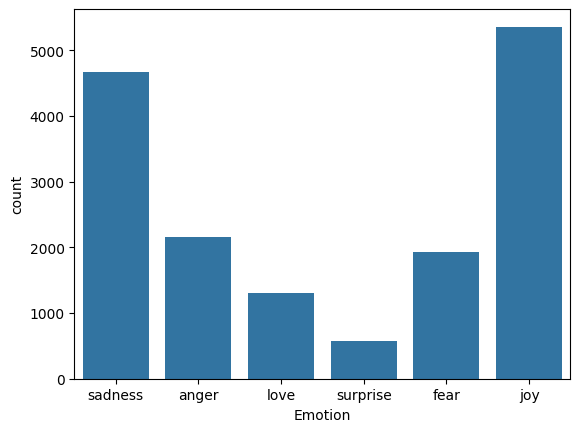

In [10]:
sns.countplot(x = train_data['Emotion'])
plt.show()

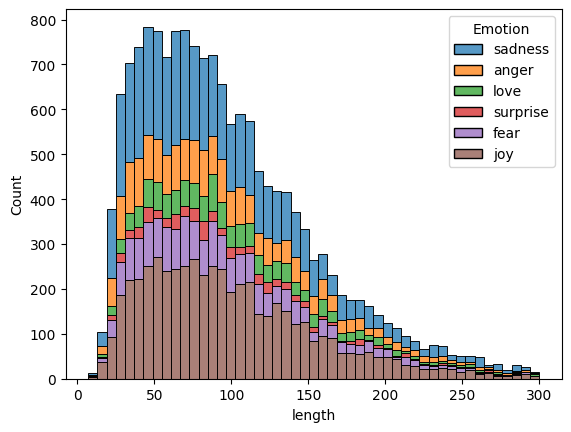

In [11]:
# data distribution
df2 = train_data.copy()
df2['length'] = [len(x) for x in df2['Comment']]

# Convert the 'length' column to a numpy array
length_values = df2['length'].values

# Use sns.histplot instead of sns.kdeplot for simplicity
sns.histplot(data=df2, x='length', hue='Emotion', multiple='stack')

plt.show()

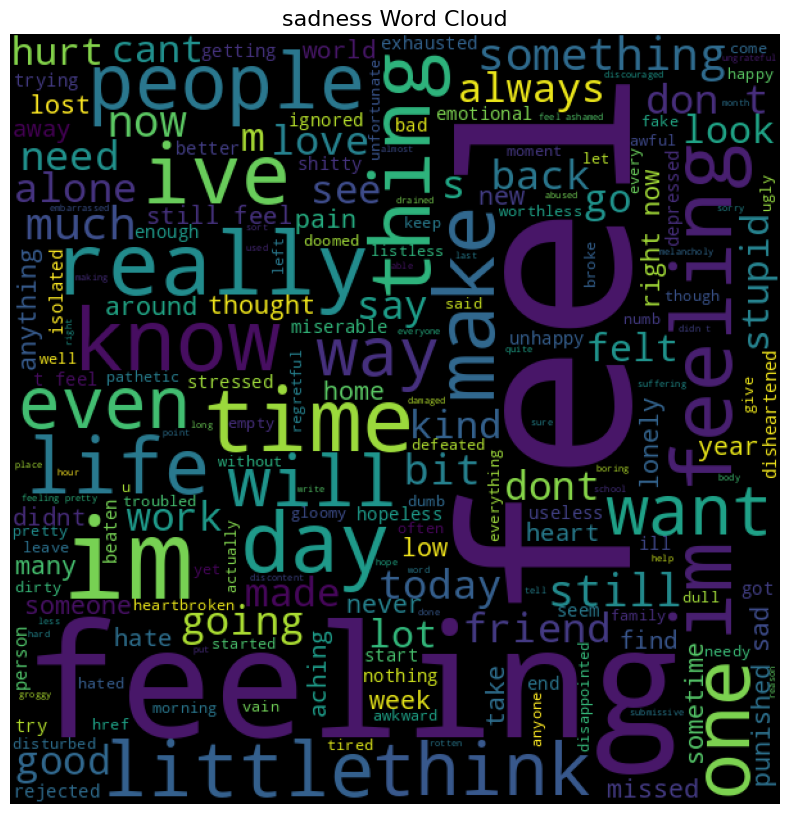

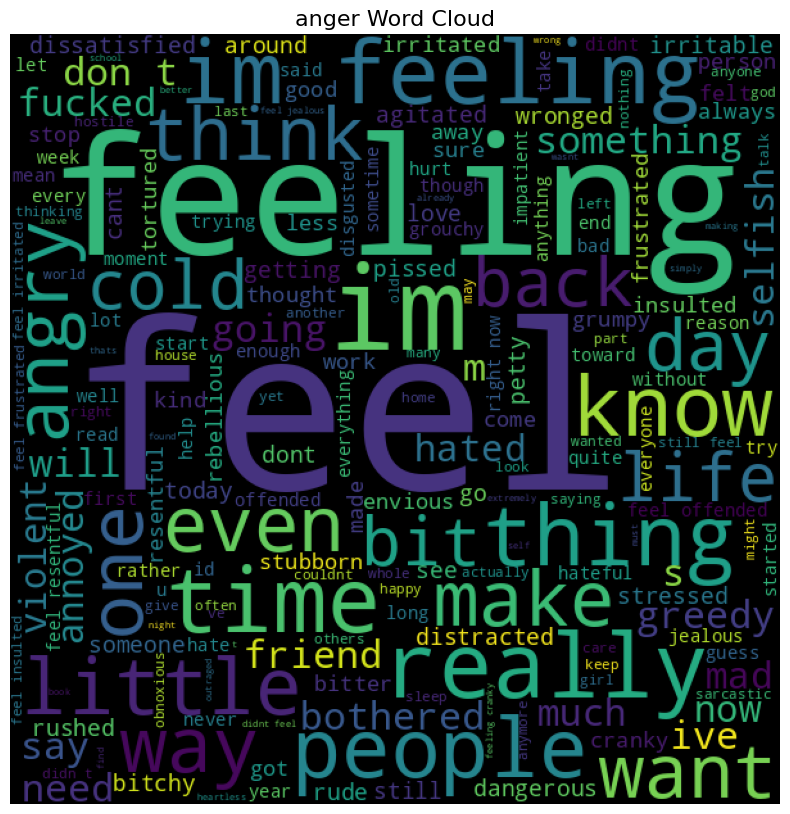

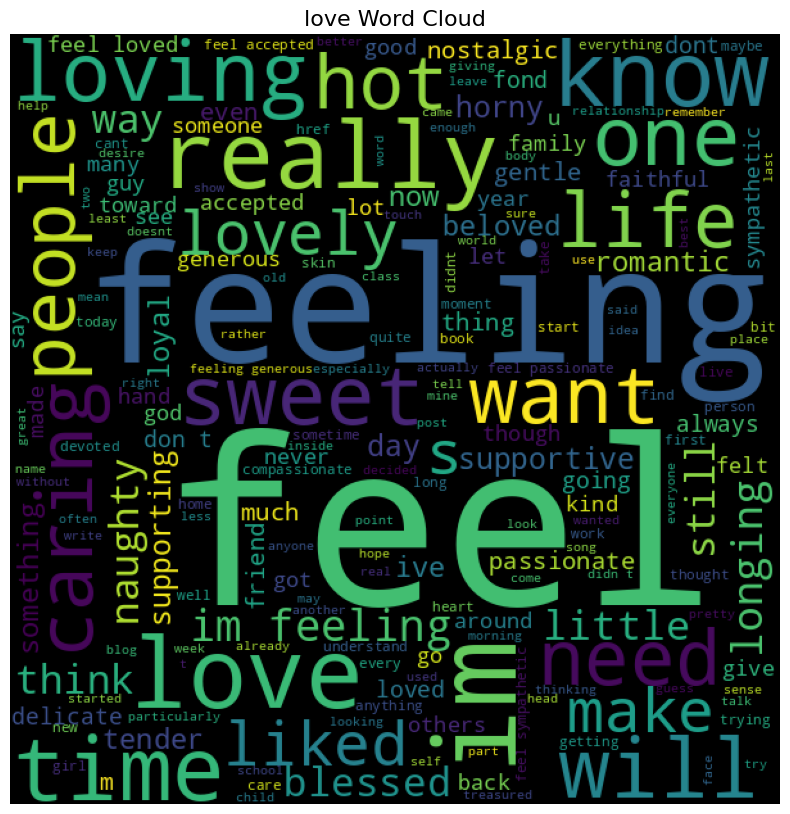

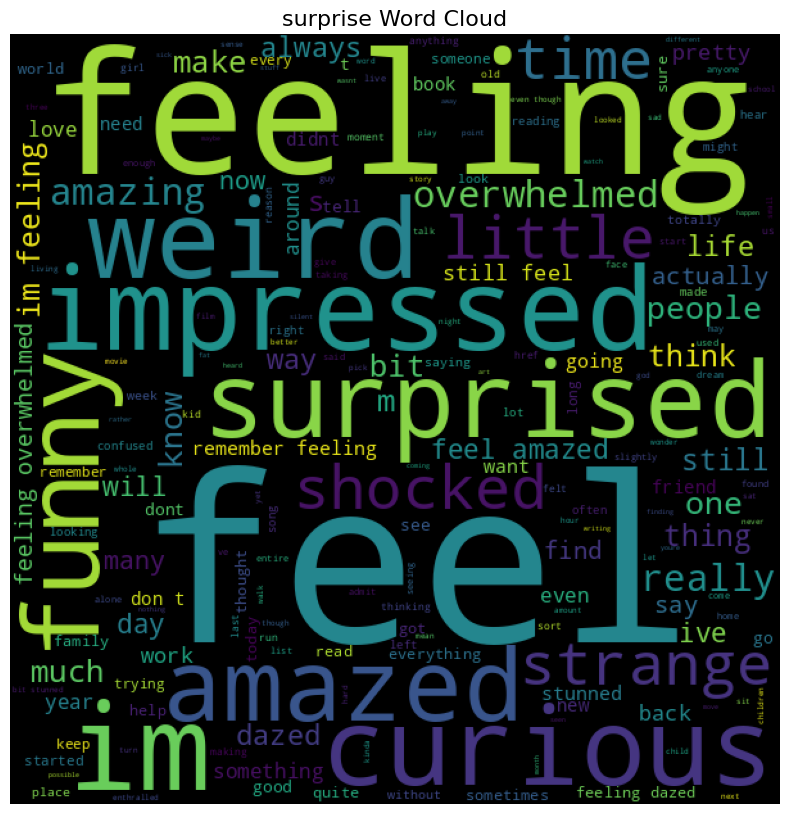

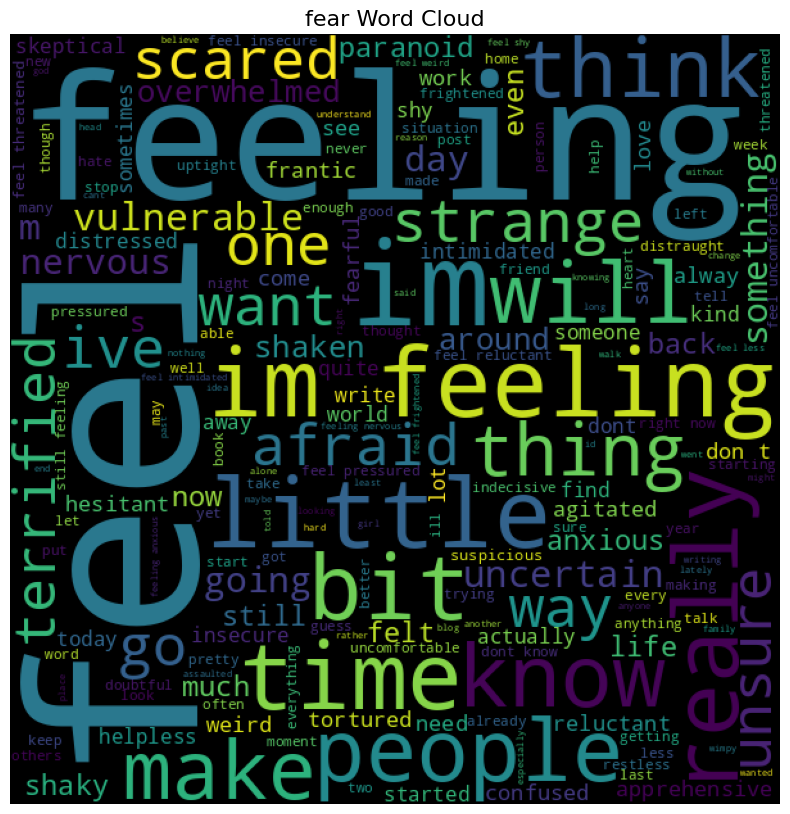

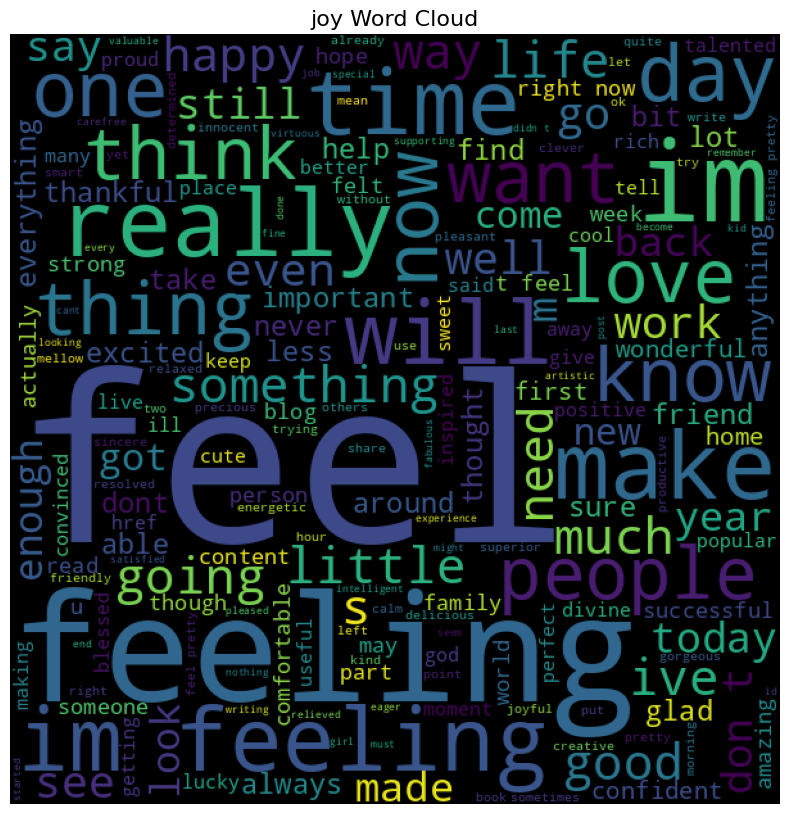

In [12]:
# Words cloud for each emotions
def words_cloud(wordcloud, df):
    plt.figure(figsize=(10, 10))
    plt.title(df+' Word Cloud', size = 16)
    plt.imshow(wordcloud)
    # No axis details
    plt.axis("off");
emotions_list = train_data['Emotion'].unique()
for emotion in emotions_list:
    text = ' '.join([sentence for sentence in train_data.loc[train_data['Emotion'] == emotion,'Comment']])
    wordcloud = WordCloud(width = 600, height = 600).generate(text)
    words_cloud(wordcloud, emotion)

## Data Preprocessing
### Encode Emotions

In [13]:
lb = LabelEncoder()
train_data['Emotion'] = lb.fit_transform(train_data['Emotion'])

In [14]:
train_data

,Comment,Emotion,length
0,i didnt feel humiliated,4,23
1,i can go from feeling so hopeless to so damned...,4,108
2,im grabbing a minute to post i feel greedy wrong,0,48
3,i am ever feeling nostalgic about the fireplac...,3,92
4,i am feeling grouchy,0,20
...,...,...,...
15995,i just had a very brief time in the beanbag an...,4,101
15996,i am now turning and i feel pathetic that i am...,4,102
15997,i feel strong and good overall,2,30
15998,i feel like this was such a rude comment and i...,0,59


## Machine Learning

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [16]:
df = train_data.copy() # copy df from train_data because we will use this for deep learing next

In [17]:
df

,Comment,Emotion,length
0,i didnt feel humiliated,4,23
1,i can go from feeling so hopeless to so damned...,4,108
2,im grabbing a minute to post i feel greedy wrong,0,48
3,i am ever feeling nostalgic about the fireplac...,3,92
4,i am feeling grouchy,0,20
...,...,...,...
15995,i just had a very brief time in the beanbag an...,4,101
15996,i am now turning and i feel pathetic that i am...,4,102
15997,i feel strong and good overall,2,30
15998,i feel like this was such a rude comment and i...,0,59


In [18]:
# Data cleaning and preprocessing
# Download NLTK stopwords
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))
def clean_text(text):
    stemmer = PorterStemmer()
    text = re.sub("[^a-zA-Z]", " ", text)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    return " ".join(text)

df['cleaned_comment'] = df['Comment'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [19]:
df

,Comment,Emotion,length,cleaned_comment
0,i didnt feel humiliated,4,23,didnt feel humili
1,i can go from feeling so hopeless to so damned...,4,108,go feel hopeless damn hope around someon care ...
2,im grabbing a minute to post i feel greedy wrong,0,48,im grab minut post feel greedi wrong
3,i am ever feeling nostalgic about the fireplac...,3,92,ever feel nostalg fireplac know still properti
4,i am feeling grouchy,0,20,feel grouchi
...,...,...,...,...
15995,i just had a very brief time in the beanbag an...,4,101,brief time beanbag said anna feel like beaten
15996,i am now turning and i feel pathetic that i am...,4,102,turn feel pathet still wait tabl sub teach degre
15997,i feel strong and good overall,2,30,feel strong good overal
15998,i feel like this was such a rude comment and i...,0,59,feel like rude comment im glad


In [20]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_comment'],df['Emotion'],test_size=0.2,random_state=42)

In [21]:
# Vectorization using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [22]:
# Multi-class classification using different algorithms
classifiers = {
    "Multinomial Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(),
}

for name, clf in classifiers.items():
    print(f"\n===== {name} =====")
    clf.fit(X_train_tfidf, y_train)
    y_pred_tfidf = clf.predict(X_test_tfidf)
    accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
    print(f"\nAccuracy using TF-IDF: {accuracy_tfidf}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred_tfidf))


===== Multinomial Naive Bayes =====

Accuracy using TF-IDF: 0.6590625
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.32      0.48       439
           1       0.88      0.23      0.37       375
           2       0.58      0.98      0.73      1027
           3       1.00      0.03      0.05       303
           4       0.72      0.91      0.80       950
           5       1.00      0.02      0.04       106

    accuracy                           0.66      3200
   macro avg       0.85      0.42      0.41      3200
weighted avg       0.76      0.66      0.59      3200


===== Logistic Regression =====


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Accuracy using TF-IDF: 0.8240625
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.78      0.83       439
           1       0.85      0.72      0.78       375
           2       0.76      0.94      0.84      1027
           3       0.83      0.46      0.59       303
           4       0.88      0.92      0.90       950
           5       0.74      0.46      0.57       106

    accuracy                           0.82      3200
   macro avg       0.82      0.71      0.75      3200
weighted avg       0.83      0.82      0.82      3200


===== Random Forest =====

Accuracy using TF-IDF: 0.85125
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       439
           1       0.82      0.86      0.84       375
           2       0.84      0.90      0.87      1027
           3       0.83      0.63      0.71       303
           4       0.92      0.88      0.90    

In [23]:
# selecting model
rf = RandomForestClassifier()
rf.fit(X_train_tfidf, y_train)
rf_y_pred = rf.predict(X_test_tfidf)

In [24]:
def predict_emotion(input_text):
    cleaned_text = clean_text(input_text)
    input_vectorized = tfidf_vectorizer.transform([cleaned_text])

    # Predict emotion
    predicted_label = rf.predict(input_vectorized)[0]
    predicted_emotion = lb.inverse_transform([predicted_label])[0]
    label =  np.max(rf.predict(input_vectorized))

    return predicted_emotion,label

# Example usage
sentences = [
            "i didnt feel humiliated",
            "i feel strong and good overall",
            "im grabbing a minute to post i feel greedy wrong",
            "He was speechles when he found out he was accepted to this new job",
            "This is outrageous, how can you talk like that?",
            "I feel like im all alone in this world",
            "He is really sweet and caring",
            "You made me very crazy",
            "i am ever feeling nostalgic about the fireplace i will know that it is still on the property",
            "i am feeling grouchy",
            "He hates you"
            ]
for sentence in sentences:
    print(sentence)
    pred_emotion, label = predict_emotion(sentence)
    print("Prediction :",pred_emotion)
    print("Label :",label)
    print("================================================================")

i didnt feel humiliated
Prediction : sadness
Label : 4
i feel strong and good overall
Prediction : joy
Label : 2
im grabbing a minute to post i feel greedy wrong
Prediction : anger
Label : 0
He was speechles when he found out he was accepted to this new job
Prediction : joy
Label : 2
This is outrageous, how can you talk like that?
Prediction : anger
Label : 0
I feel like im all alone in this world
Prediction : sadness
Label : 4
He is really sweet and caring
Prediction : anger
Label : 0
You made me very crazy
Prediction : anger
Label : 0
i am ever feeling nostalgic about the fireplace i will know that it is still on the property
Prediction : love
Label : 3
i am feeling grouchy
Prediction : anger
Label : 0
He hates you
Prediction : anger
Label : 0


In [25]:
# save files
import pickle
pickle.dump(rf,open("random_forrest_classifier.pkl",'wb'))
pickle.dump(lb,open("label_encoder.pkl",'wb'))
pickle.dump(tfidf_vectorizer,open("tfidf_vectorizer.pkl",'wb'))

## Applying deep learning using LSTM
### Applying Text Cleaning, Encoding, Padding

In [26]:
# Text cleaning function
def text_cleaning(df, column, vocab_size, max_len):
    stemmer = PorterStemmer()
    corpus = []

    for text in df[column]:
        text = re.sub("[^a-zA-Z]", " ", text)
        text = text.lower()
        text = text.split()
        text = [stemmer.stem(word) for word in text if word not in stopwords]
        text = " ".join(text)
        corpus.append(text)

    one_hot_word = [one_hot(input_text=word, n=vocab_size) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word, maxlen=max_len, padding='pre')
    return pad

# Text cleaning and encoding
x_train = text_cleaning(train_data, "Comment", vocab_size=11000, max_len=300)
y_train = to_categorical(train_data["Emotion"])

## Model Builiding and Training

In [28]:
# Build and compile the model
model = Sequential()
model.add(Embedding(input_dim=11000, output_dim=150, input_length=300))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
callback = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
model.fit(x_train, y_train, epochs=20, batch_size=64, verbose=1, callbacks=[callback])

Epoch 1/20
249/250 [============================>.] - ETA: 0s - loss: 1.4079 - accuracy: 0.4589

250/250 [==============================] - 30s 81ms/step - loss: 1.4075 - accuracy: 0.4593
Epoch 2/20
250/250 [==============================] - ETA: 0s - loss: 0.6803 - accuracy: 0.7645

250/250 [==============================] - 7s 27ms/step - loss: 0.6803 - accuracy: 0.7645
Epoch 3/20
250/250 [==============================] - ETA: 0s - loss: 0.3080 - accuracy: 0.9012

250/250 [==============================] - 6s 23ms/step - loss: 0.3080 - accuracy: 0.9012
Epoch 4/20
250/250 [==============================] - ETA: 0s - loss: 0.2100 - accuracy: 0.9275

250/250 [==============================] - 5s 21ms/step - loss: 0.2100 - accuracy: 0.9275
Epoch 5/20
250/250 [==============================] - ETA: 0s - loss: 0.1608 - accuracy: 0.9457

250/250 [==============================] - 7s 26ms/step - loss: 0.1608 - accuracy: 0.9457
Epoch 6/20
247/250 [============================>.] - ETA: 0s - loss: 0.1282 - accuracy: 0.9574

250/250 [==============================] - 5s 19ms/step - loss: 0.1285 - accuracy: 0.9572
Epoch 7/20
250/250 [==============================] - ETA: 0s - loss: 0.1048 - accuracy: 0.9634

250/250 [==============================] - 4s 16ms/step - loss: 0.1048 - accuracy: 0.9634
Epoch 8/20
249/250 [============================>.] - ETA: 0s - loss: 0.0926 - accuracy: 0.9659

250/250 [==============================] - 4s 18ms/step - loss: 0.0924 - accuracy: 0.9659
Epoch 9/20
249/250 [============================>.] - ETA: 0s - loss: 0.0792 - accuracy: 0.9729

250/250 [==============================] - 4s 16ms/step - loss: 0.0795 - accuracy: 0.9727
Epoch 10/20
250/250 [==============================] - ETA: 0s - loss: 0.0649 - accuracy: 0.9774

250/250 [==============================] - 4s 17ms/step - loss: 0.0649 - accuracy: 0.9774
Epoch 11/20
247/250 [============================>.] - ETA: 0s - loss: 0.0691 - accuracy: 0.9765

250/250 [==============================] - 5s 20ms/step - loss: 0.0690 - accuracy: 0.9764
Epoch 12/20
248/250 [============================>.] - ETA: 0s - loss: 0.0576 - accuracy: 0.9804

250/250 [==============================] - 4s 16ms/step - loss: 0.0578 - accuracy: 0.9804
Epoch 13/20
249/250 [============================>.] - ETA: 0s - loss: 0.0553 - accuracy: 0.9811

250/250 [==============================] - 4s 16ms/step - loss: 0.0552 - accuracy: 0.9811
Epoch 14/20
249/250 [============================>.] - ETA: 0s - loss: 0.0527 - accuracy: 0.9828

250/250 [==============================] - 5s 19ms/step - loss: 0.0528 - accuracy: 0.9827
Epoch 15/20
248/250 [============================>.] - ETA: 0s - loss: 0.0477 - accuracy: 0.9834

250/250 [==============================] - 4s 16ms/step - loss: 0.0476 - accuracy: 0.9834
Epoch 16/20
250/250 [==============================] - ETA: 0s - loss: 0.0443 - accuracy: 0.9844

250/250 [==============================] - 4s 17ms/step - loss: 0.0443 - accuracy: 0.9844
Epoch 17/20
250/250 [==============================] - ETA: 0s - loss: 0.0456 - accuracy: 0.9844

250/250 [==============================] - 4s 17ms/step - loss: 0.0456 - accuracy: 0.9844
Epoch 18/20
250/250 [==============================] - ETA: 0s - loss: 0.0366 - accuracy: 0.9872

250/250 [==============================] - 4s 17ms/step - loss: 0.0366 - accuracy: 0.9872
Epoch 19/20
248/250 [============================>.] - ETA: 0s - loss: 0.0347 - accuracy: 0.9872

250/250 [==============================] - 5s 18ms/step - loss: 0.0346 - accuracy: 0.9872
Epoch 20/20
248/250 [============================>.] - ETA: 0s - loss: 0.0352 - accuracy: 0.9875

250/250 [==============================] - 4s 16ms/step - loss: 0.0357 - accuracy: 0.9874


## Predictive System

In [29]:
# Text cleaning function
def sentence_cleaning(sentence):
    stemmer = PorterStemmer()
    corpus = []
    text = re.sub("[^a-zA-Z]", " ", sentence)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    text = " ".join(text)
    corpus.append(text)
    one_hot_word = [one_hot(input_text=word, n=11000) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word, maxlen=300, padding='pre')
    return pad

# load model and predict
sentences = [
            "i feel strong and good overall",
            "im grabbing a minute to post i feel greedy wrong",
            "He was speechles when he found out he was accepted to this new job",
            "This is outrageous, how can you talk like that?",
            "I feel like im all alone in this world",
            "He is really sweet and caring",
            "You made me very crazy",
            "i am ever feeling nostalgic about the fireplace i will know that it is still on the property",
            "i am feeling grouchy",
            "He hates you"
            ]
for sentence in sentences:
    print(sentence)
    sentence = sentence_cleaning(sentence)
    result = lb.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba =  np.max(model.predict(sentence))
    print(f"{result} : {proba}\n\n")

i feel strong and good overall
1/1 [==============================] - 0s 32ms/step
joy : 0.999956488609314


im grabbing a minute to post i feel greedy wrong
1/1 [==============================] - 0s 61ms/step
anger : 0.9995782971382141


He was speechles when he found out he was accepted to this new job
1/1 [==============================] - 0s 37ms/step
fear : 0.5406194925308228


This is outrageous, how can you talk like that?
1/1 [==============================] - 0s 32ms/step
anger : 0.9841949939727783


I feel like im all alone in this world
1/1 [==============================] - 0s 47ms/step
sadness : 0.9995564818382263


He is really sweet and caring
1/1 [==============================] - 0s 61ms/step
love : 0.9665064215660095


You made me very crazy
1/1 [==============================] - 0s 101ms/step
sadness : 0.954861581325531


i am ever feeling nostalgic about the fireplace i will know that it is still on the property
1/1 [==============================] - 0s 52ms/step
lo

In [30]:
model.save('model1.h5')

# Save the LabelEncoder
with open('lb1.pkl', 'wb') as f:
    pickle.dump(lb, f)

# Save vocabulary size and max length
vocab_info = {'vocab_size': 11000, 'max_len': 300}
with open('vocab_info.pkl', 'wb') as f:
    pickle.dump(vocab_info, f)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
